In [1]:
import os
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.drive_and_act_keypoint_dataset import DriveAndActKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.utils.visualization import (
    plot_samples
)
from IPython.display import display
from pathlib import Path

pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/data/processed/drive_and_act/')
keypoint_2d_path = dataset_root_path / 'keypoint_detection_results'
keypoint_3d_path = dataset_root_path / 'annotations'
bbox_file = dataset_root_path / 'person_detection_results'
# ------------
# model
# ------------
image_width = 1280
image_height = 1024
batch_size = 64
max_epoch = 200
val_check_period = 5
early_stopping_patience = 5
# ------------
# saved model path
# ------------
saved_model_path = './saved_lifter_2d_3d_model/linear_model/drive_and_act/A_Pillar_Codriver/predicted_2d/all_actors/'


train_dataset = DriveAndActKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    bbox_file=(bbox_file / 'human_detection_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    # actors=['vp1', 'vp4', 'vp5', 'vp6', 'vp7', 'vp8', 'vp9', 'vp10', 'vp15'],
    actors=['vp1', 'vp2', 'vp3', 'vp4', 'vp5', 'vp6', 'vp7', 'vp8'],
    exclude_ankle=True,
    exclude_knee=True,
    # is_normalize_to_bbox=True,
    # bbox_format='xyxy'

    is_center_to_neck=True,
    is_normalize_to_bbox=False,
    is_normalize_to_pose=True,
)
val_dataset = DriveAndActKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    bbox_file=(bbox_file / 'human_detection_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    # actors=['vp2', 'vp3'],
    actors=['vp9', 'vp10', 'vp15'],
    exclude_ankle=True,
    exclude_knee=True,
    # is_normalize_to_bbox=True,
    # bbox_format='xyxy'

    is_center_to_neck=True,
    is_normalize_to_bbox=False,
    is_normalize_to_pose=True,
)
test_dataset = DriveAndActKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    bbox_file=(bbox_file / 'human_detection_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    actors=['vp11', 'vp12', 'vp13', 'vp14'],
    # actors=['vp13', 'vp14', 'vp15'],
    exclude_ankle=True,
    exclude_knee=True,
    # is_normalize_to_bbox=True,
    # bbox_format='xyxy'
    
    is_center_to_neck=True,
    is_normalize_to_bbox=False,
    is_normalize_to_pose=True,
)
all_activities = train_dataset.activities.union(val_dataset.activities).union(test_dataset.activities)
lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_knee=True, all_activities=all_activities, is_silence=False, learning_rate=1e-3)
print(
    'train_dataset', len(train_dataset),
    'val_dataset', len(val_dataset),
    'test_dataset', len(test_dataset)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=24)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=24)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)


model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience)

if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(
    # max_steps=10,
    max_epochs=max_epoch,
    callbacks=[model_checkpoint, early_stopping],
    accelerator=device,
    check_val_every_n_epoch=val_check_period,
    default_root_dir=saved_model_path,
    gradient_clip_val=1.0
)
trainer.fit(lit_model, train_loader, val_loader)

Global seed set to 1234


skipping problematic image 3628
skipping problematic image 5874
skipping problematic image 14835
skipping problematic image 15783
skipping problematic image 17258
skipping problematic image 17259
skipping problematic image 21271
skipping problematic image 21272
skipping problematic image 21273
skipping problematic image 21274
skipping problematic image 21275
skipping problematic image 21276
skipping problematic image 32959
skipping problematic image 33527
skipping problematic image 28113
train_dataset 22881 val_dataset 6240 test_dataset 11017


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | BaselineModel | 4.3 M 
----------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.105    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

check #0
val MPJPE from: 128 samples : 2500.265121459961


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

check #1
training loss from 1785 batches: 560.663539137827
val MPJPE from: 6208 samples : 103.88928651809692


Validation: 0it [00:00, ?it/s]

check #2
training loss from 1785 batches: 128.01269873016687
val MPJPE from: 6208 samples : 80.30815422534943


Validation: 0it [00:00, ?it/s]

check #3
training loss from 1785 batches: 113.75928425571831
val MPJPE from: 6208 samples : 78.28837633132935


Validation: 0it [00:00, ?it/s]

check #4
training loss from 1785 batches: 108.37284708891262
val MPJPE from: 6208 samples : 78.24977487325668


Validation: 0it [00:00, ?it/s]

check #5
training loss from 1785 batches: 105.89097670229877
val MPJPE from: 6208 samples : 79.12571728229523


Validation: 0it [00:00, ?it/s]

check #6
training loss from 1785 batches: 104.19927465231144
val MPJPE from: 6208 samples : 77.82692462205887


Validation: 0it [00:00, ?it/s]

check #7
training loss from 1785 batches: 102.6701712933909
val MPJPE from: 6208 samples : 76.43914222717285


Validation: 0it [00:00, ?it/s]

check #8
training loss from 1785 batches: 101.48489974877413
val MPJPE from: 6208 samples : 77.04208791255951


Validation: 0it [00:00, ?it/s]

check #9
training loss from 1785 batches: 100.58710814273658
val MPJPE from: 6208 samples : 76.11030340194702


Validation: 0it [00:00, ?it/s]

check #10
training loss from 1785 batches: 99.81871840416217
val MPJPE from: 6208 samples : 75.5416601896286


Validation: 0it [00:00, ?it/s]

check #11
training loss from 1785 batches: 99.09771465036383
val MPJPE from: 6208 samples : 76.42380893230438


Validation: 0it [00:00, ?it/s]

check #12
training loss from 1785 batches: 98.68281054563549
val MPJPE from: 6208 samples : 76.01472735404968


Validation: 0it [00:00, ?it/s]

check #13
training loss from 1785 batches: 98.35863815469234
val MPJPE from: 6208 samples : 76.60327851772308


Validation: 0it [00:00, ?it/s]

check #14
training loss from 1785 batches: 97.8374583297083
val MPJPE from: 6208 samples : 75.48634707927704


Validation: 0it [00:00, ?it/s]

check #15
training loss from 1785 batches: 97.58705173720833
val MPJPE from: 6208 samples : 76.1970803141594


Validation: 0it [00:00, ?it/s]

check #16
training loss from 1785 batches: 97.29910050870993
val MPJPE from: 6208 samples : 76.18917524814606


Validation: 0it [00:00, ?it/s]

check #17
training loss from 1785 batches: 97.23343130211536
val MPJPE from: 6208 samples : 75.90942829847336


Validation: 0it [00:00, ?it/s]

check #18
training loss from 1785 batches: 96.91264999179947
val MPJPE from: 6208 samples : 75.60130208730698


Validation: 0it [00:00, ?it/s]

check #19
training loss from 1785 batches: 96.85163332634613
val MPJPE from: 6208 samples : 76.27029716968536


In [2]:
with open(f'{saved_model_path}/best_model_path.txt', 'w') as f:
    f.writelines(model_checkpoint.best_model_path)
best_checkpoint_path = model_checkpoint.best_model_path
trainer.test(ckpt_path=best_checkpoint_path, dataloaders=test_loader)

Restoring states from the checkpoint path at saved_lifter_2d_3d_model/linear_model/drive_and_act/A_Pillar_Codriver/predicted_2d/all_actors/lightning_logs/version_34/checkpoints/epoch=69-step=24990.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/linear_model/drive_and_act/A_Pillar_Codriver/predicted_2d/all_actors/lightning_logs/version_34/checkpoints/epoch=69-step=24990.ckpt


Testing: 0it [00:00, ?it/s]

MPJPE: 63.47513639534433
PJPE
                      PJPE
nose             52.148683
left_eye         49.560749
right_eye        48.154686
left_ear         14.252222
right_ear        39.029978
left_shoulder    29.208940
right_shoulder   30.221626
left_elbow       65.070838
right_elbow      71.714760
left_wrist       82.552066
right_wrist     100.587540
left_hip         59.317945
right_hip        59.038777
activities_mpjpe:
{'sitting_still': 57.76046343722136, 'entering_car': 217.16044297040747, 'closing_door_inside': 132.31343838703083, 'drinking': 80.08403084825765, 'fetching_an_object': 161.47820584849475, 'pressing_automation_button': 58.655811532521106, 'closing_bottle': 81.8061759982241, 'opening_bottle': 72.04980109769416, 'preparing_food': 132.24086632929212, 'opening_backpack': 221.8247676973298, 'eating': 61.961069104776165, 'placing_an_object': 152.75348945954033, 'reading_newspaper': 84.37499059284622, 'writing': 91.86653295118066, 'taking_off_sunglasses': 110.15017470473985,

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │     63.47513639534433     │
└───────────────────────────┴───────────────────────────┘

[{'mpjpe': 63.47513639534433}]

In [3]:
pd.DataFrame(lit_model.test_history[0]['activities_mpjpe'], index=['mpjpe']).T.sort_values('mpjpe')

,mpjpe
sitting_still,57.760463
pressing_automation_button,58.655812
eating,61.961069
reading_magazine,62.131668
opening_bottle,72.049801
working_on_laptop,76.294576
drinking,80.084031
interacting_with_phone,81.319927
closing_bottle,81.806176
reading_newspaper,84.374991


In [4]:
pd.DataFrame(lit_model.test_history[0]['activities_mpjpe'], index=['mpjpe']).T.mean()

mpjpe    133.247741
dtype: float64

[347.3514, 286.7826, 657.2451, 620.2427]
[355.2612, 290.0608, 650.605, 605.4089]
[343.4412, 268.8018, 686.1542, 479.4213]


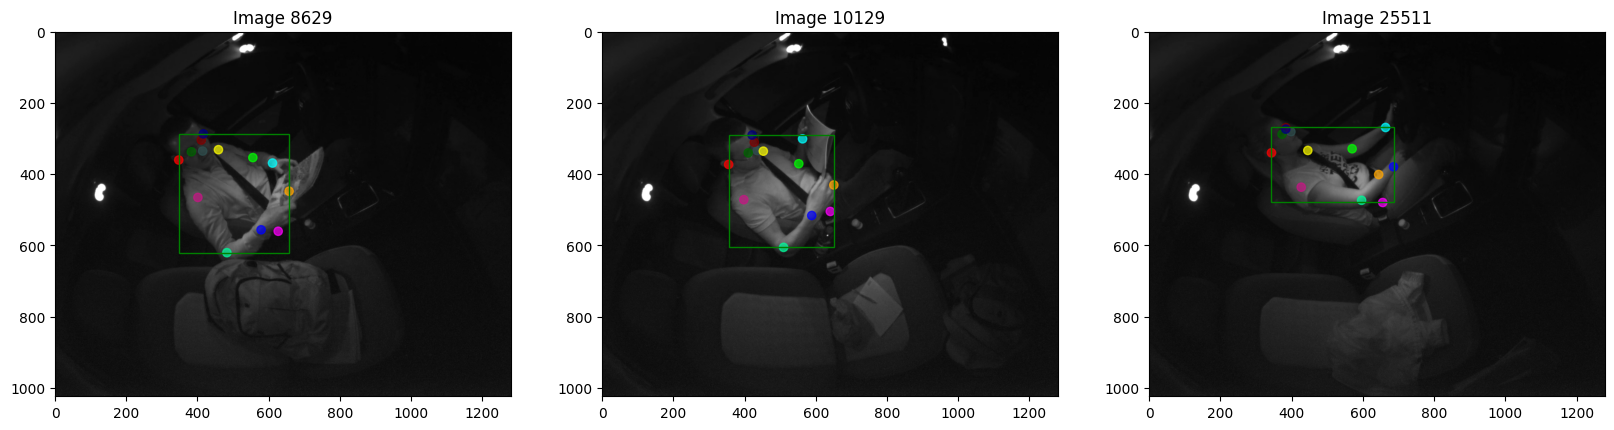

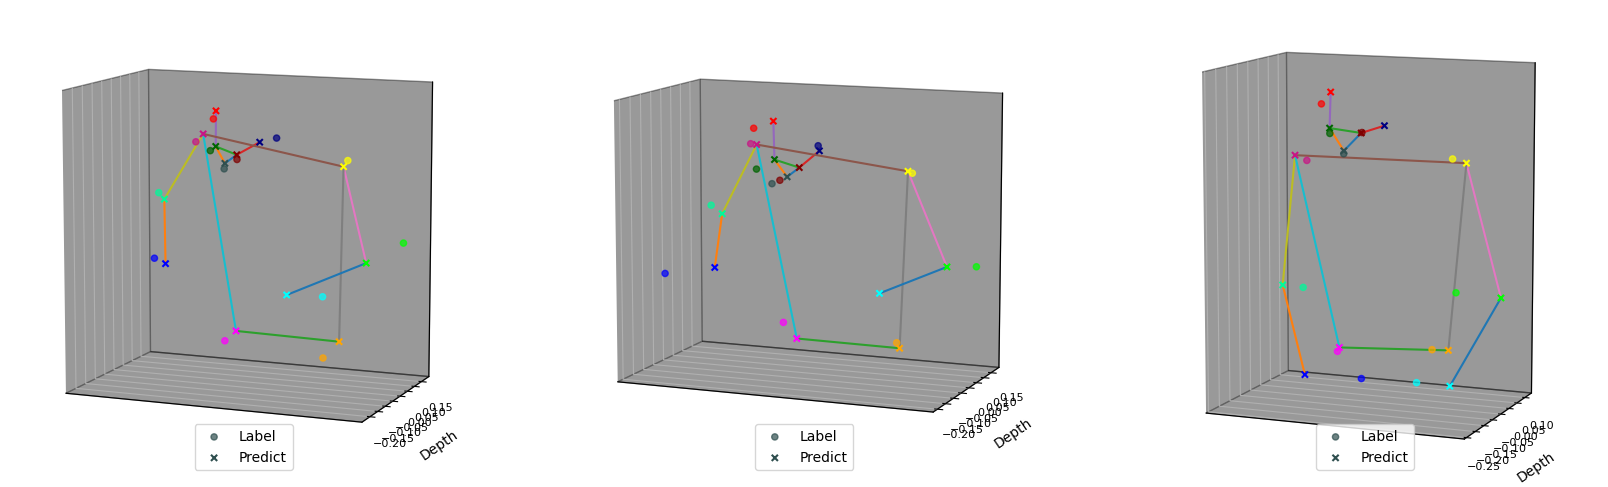

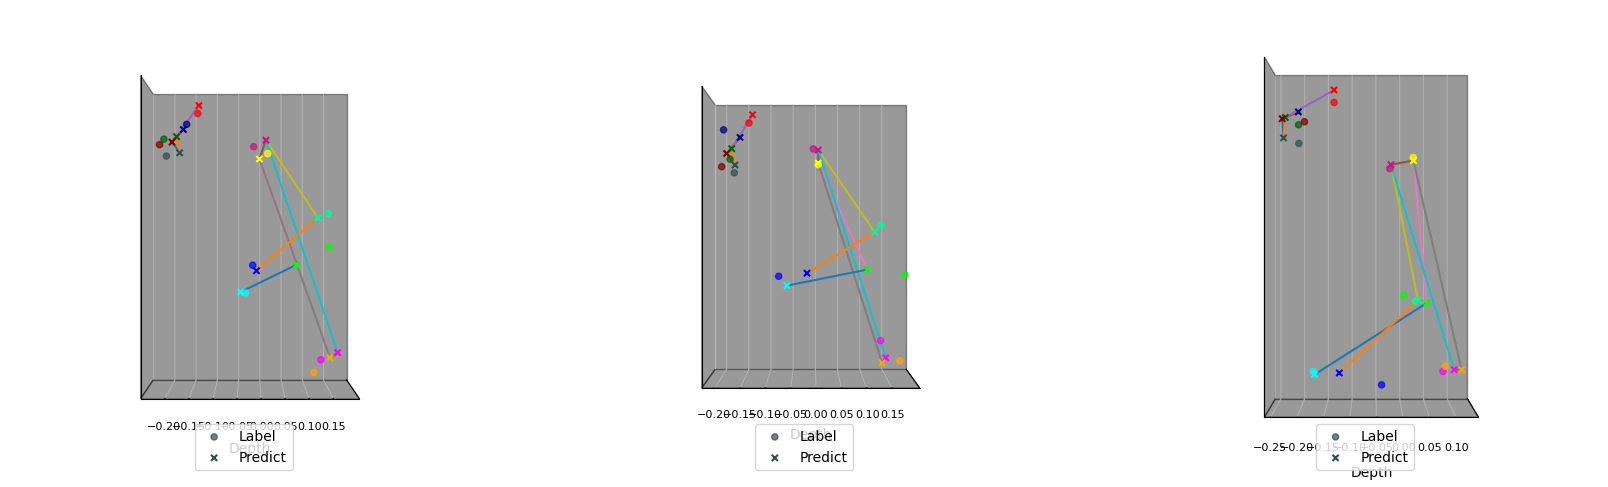

In [6]:
plot_samples(
    dataset_root_path,
    trainer.model,
    test_loader,
    'train',
    img_figsize=(20, 10),
    plot_figsize=(20.5, 10),
    sample_idices=[1000, 2500, 6000],
    is_plot_gt_skeleton=False
)